![Titlepic](Images/xyz_tnr_machine.png)

# Introduction

This paper describes how to derive the kinematic model for a 5-axis machine tool in an XYZBC configuration with work side B,C rotation. In this example the B axis is the primary and the C axis is the secondary rotary axis. The primary being independent of the secondary axis. The secondary axis being the one closest to the work piece. The model presented here will be named 'XYZBC-TNR'.

The method used here will be a step by step approach. Starting with a working kinematic model for a single rotary axis all the required elements will be added to build a complete kinematic model for the machine.

The final model includes tool-length compensation, compensation for mechanical offsets between the two rotational axes B and C and compensation for setups where the machine reference point is not located in the center of the C rotary table. The nutation angle is adjustable from 0 to 90° as measured from the vertical. 
The kinematics derived here is also applicable to XYZAC configurations since the orientation of the nutating joint (referred to as the 'table angle') is adjustable by 0-90°. 

In this document only basic mathematical functions are used so the kinematic models derived can be used directly in the 'userkins.comp' template file provided with the LinuxCNC installation. All calculations can be done without the use of any computer algebra systems, however the use of computer assistance like 'sage' will make the process of matrix multiplication much less error prone.

Note that there are other and potentially more computationally efficient ways to build custom kinematics using built in libraries like 'posemath'. Posemath provides many functions for efficient matrix manipulation and also offers functions for the use of quaternions. However the use of such a library would require a more indepth understanding of the mathematical theory that is beyond the scope of this presentation. Furthermore importing a library like 'posemath' into the 'userkins.comp' template would require substantially more programming skills than using the method applied in this paper.


In [1]:
from IPython.display import display, Image

# only used to display equations out of code blocks
from IPython.display import Math, display

# joint position vector P 
var('Px','Py','Pz')
P_=matrix([[Px],
           [Py],
           [Pz],
           [1]])

# cartesian position vector Q
var('Qx','Qy','Qz')
Q_=matrix([[Qx],
           [Qy],
           [Qz],
           [1]])

A custom kinematic model in LinuxCNC is used to calculate cartesian coordinates from given machine joint positions (forward kinematics) and also to calculate the required machine joint positions to reach a given coordinate position (inverse kinematics). In the following description we will use vectors as mathematical representations of the two positions: 


\begin{equation}
Q ~=~
\left(\begin{array}{rrrr}
  Qx \\
  Qy \\
  Qz \\
  1
\end{array}\right)
~
Cartesian~position
~~~~~~~~~~~~
P ~=~
\left(\begin{array}{rrrr}
  Px \\
  Py \\
  Pz \\
  1
\end{array}\right)
~
Joint~position
\end{equation}

Note that the fourth row is added to be able to multiply the vectors with a 4x4 transformation matrix. 

# Kinematic transformation 

The kinematic model consists of a 'Forward' transformation and an 'Inverse' transformation. <br>
The forward transformation uses known machine joint locations and calculates the corresponding axis locations (ie any XYZABCUVW) usually tool position and orientation in the work space. In Linuxcnc the forward kinematic is used to calculate the initial axis positions after homing the machine.<br>
The inverse transformation calculates the required machine joint positions to move the control point (usually the tool tip) to the given coordinates (ie XYZABCUVW). 

# TCP Kinematic model
For the tool to follow a point on the work piece we need a model that calculates where a given position on the work piece moves to when the rotary joints are rotated. In our example configuration the work piece will be mounted on the C rotary table.<br>

For the forward kinematic model we start at the tool side and work along the kinematic chain towards the work piece so we will start with the primary rotary.<br>


Note that in matrix multiplication the order is important that is $A\cdot B$ is generally not equal to $B \cdot A$. 


## Table Primary Rotation
### How to derive a rotation matrix for a nutating joint

The machine in our example has a 'nutating' primary rotary joint. Nutating meaning here that the rotational axis is not parallel to any of the axes (x, y or z) of our machine coordinate system and hence we cannot use any of the basic rotation matrices to model it in our kinematic. The basic rotation matrices are only three particular solutions of a general formula to describe rotations around any given vector $V(v_x, v_y, v_z$) in space.
In our particular case we will see that a regular (ie orthogonal) rotary assembly corresponds to a nutation angle of 90° and our kinematic model will also cover this particular machine type.<br>
To construct the rotation matrix $R_p$ for the slanted primary joint of our table we will use the ‘Rodrigues' form of the general rotation formula. (Note that there is also an 'Euler-Rodrigues' formula that can be used for the same purpose but uses different parameters.)

\begin{equation}
R_p ~=~ I ~+~ sin\theta \cdot V + (2sin²{\theta \over2}) \cdot V²
\label{eq:rod_rot}
\end{equation}
where $\theta$ is the angle of positive rotation around a vector $\vec{v}$ acording to the 'Right-Hand' rule.

With:
\begin{equation}
I ~=~ 
\left(\begin{array}{rrrr}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1 
\end{array}\right)
~~
V ~=~
\left(\begin{array}{rrrr}
  0  & -v_z &  v_y \\
 v_z &   0  & -v_x  \\
-v_y &  v_x  &   0 
\end{array}\right)
\label{eq:mat_I_V}
\end{equation}

For the matrix $V$ we need a unit vector that represents the rotational axis of the nutating joint:

$$\vec{v}=(v_x,v_y,v_z)$$

In our case the nutating axis lies in the YZ-plane and has the components:

$$v_x=0, ~~~~ v_y = -sin\nu, ~~~~ v_z = cos\nu$$ 

where $\nu$ is the angle of the nutating axis as measured from the vertical.


Using the definitions of $I$ and $V$ we can rewrite  $R_p $ as:

\begin{equation}
R_p ~=~
\left(\begin{array}{rrrr}
  cos\theta+v²_x(1-cos\theta)   &   v_x v_y(1-cos\theta)-v_z sin\theta  &  v_x v_z(1-cos\theta)+v_y sin\theta \\
  v_x v_y(1-cos\theta)+v_z sin\theta  &   cos\theta+v²_y(1-cos\theta)   &  v_y v_z(1-cos\theta)-v_x sin\theta \\
  v_x v_z(1-cos\theta)-v_y sin\theta  &   v_y v_z(1-cos\theta)+v_x sin\theta   &   cos\theta+v²_z(1-cos\theta) 
\end{array}\right)
\end{equation}


For simplicity we substitute 
$$sin\nu = Sv, ~~~~ cos\nu = Cv, ~~~~ sin\theta = Sp, ~~~ cos\theta = Cp$$

using the components of $\vec{v}$ the rotation matrix of our primary joint now becomes

\begin{equation}
R_p ~=~
\left(\begin{array}{rrrr}
   Cp   &          -CvSp         &       -SvSp       \\
  CvSp  &      Cp + S²v(1-Cp)    &    -SvCv(1-Cp)    \\
  SvSp  &       -SvCv(1-Cp)      &   Cp + C²v(1-Cp) 
\end{array}\right)
\end{equation}

and by expanding it to a 4x4 matrix we have now the required transformation matrix

\begin{equation}
R_p ~=~
\left(\begin{array}{rrrr}
   Cp   &           -CvSp        &       -SvSp        &      0     \\
  CvSp  &      Cp + S²v(1-Cp)    &    -SvCv(1-Cp)     &      0     \\
  SvSp  &       -SvCv(1-Cp)      &   Cs + C²v(1-Cp)   &      0     \\
   0    &             0          &         0          &      1
\end{array}\right)
\end{equation}


To make the matrix multiplications more manageable we substitute 


$$ Cp + S²v(1-Cp)~=~ r   ~~~~~~~~  Cp + C²v(1-Cp) ~=~ s ~~~~~~~~ -SvCv(1-Cp) ~=~ t  $$ 

and get the transformation matrix in it's final form

\begin{equation}
R_p ~=~
\left(\begin{array}{rrrr}
   Cp   &   -CvSp  &  -SvSp &  0     \\
  CvSp  &    r    &    t    &  0     \\
  SvSp  &    t    &    s    &  0     \\
   0    &    0    &    0    &  1
\end{array}\right)
\end{equation}

Since in CNC machining we usually want the positive rotation to be in relation to the tool rotation and we are describing a table (ie a work side rotation) we actually want to use the inverted matrix $R_p$ for our forward kinematics.

\begin{equation}
R_p ~=~
\left(\begin{array}{rrrr}
   Cp   &   CvSp  &   SvSp  &  0     \\
 -CvSp  &    r    &    t    &  0     \\
 -SvSp  &    t    &    s    &  0     \\
   0    &    0    &    0    &  1
\end{array}\right)
\end{equation}


 with $~~Sp = sin(\theta_s),~~~ Cp = cos(\theta_p)$
and $\theta_p$ being the angle of rotation around the primary rotary joint

In [2]:
# define the transformation matrix for the primary rotary joint
var('Cp','CvSp','SvSp','r','s','t')
Rn=matrix([[ Cp  ,  CvSp,  SvSp, 0],
           [-CvSp,     r,     t, 0],
           [-SvSp,     t,     s, 0],
           [    0,     0,     0, 1]])
display(Math(rf'R_n =~'+latex(Rn)))

<IPython.core.display.Math object>

## Orientation of the Primary Rotation

Some machines do not have the primary rotational axis in the yz-plane but rotated by some angle around the vertical(eg the DMU eVo series). Also a machine with an XYZAC table rotary kinematic is essentially the same as our XYZBC table rotary but with the primary rotational axis rotated by 90°. Hence it would be useful to build this into our kinematics model as a variable table rotation. 

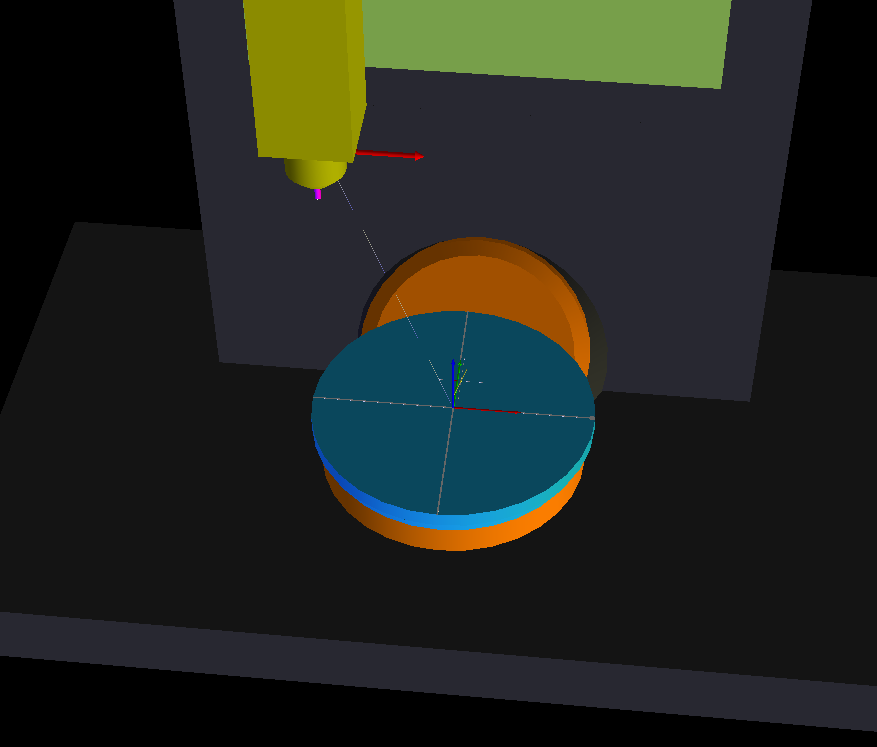

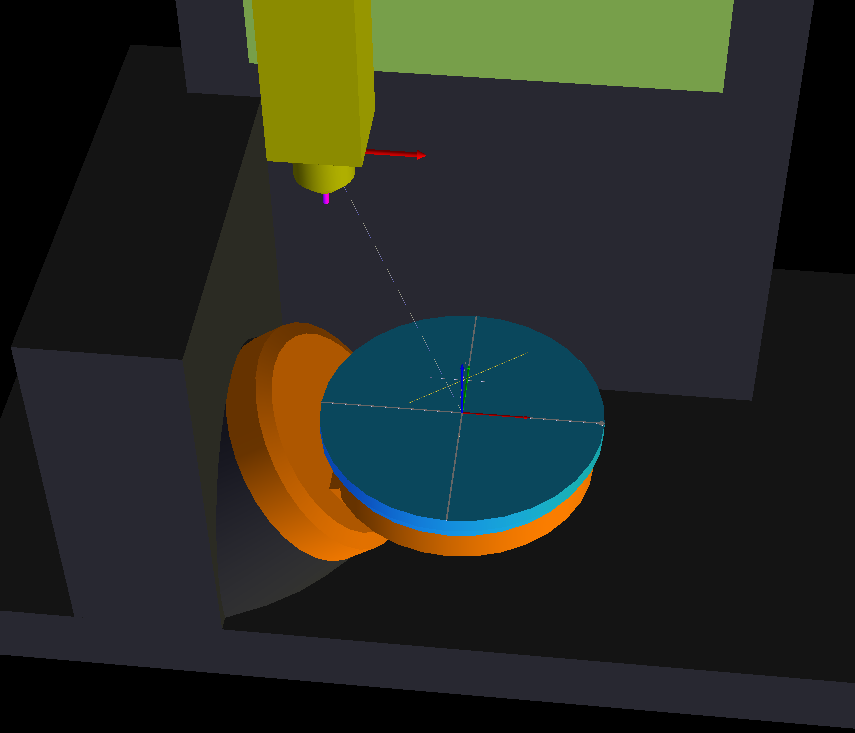

In [3]:
display(Image(filename="Images/table_0.png", height=500, width=500), Image(filename="Images/table_90.png", height=500, width=500))

This rotation can be modelled by a rotation matrix $R_t$:
with $~~Su = sin(\theta_\mu),~~~ Cu = cos(\theta_\mu)$
and $\theta_\mu$ being the angle of rotation of the primary rotational joint.

In [4]:
# define transformation matrix for the table-orientation (ie rotation of the rotary assembly around z-axis)
var('Cu','Su')
Rt=matrix([[  Cu, -Su,   0, 0],
           [  Su,  Cu,   0, 0],
           [  0 ,  0 ,   1, 0],
           [  0,   0 ,   0, 1]])
display(Math(rf'R_t =~'+latex(Rt)))

<IPython.core.display.Math object>

There is however an issue that needs to be addressed:
On a real machine, like the XYZBC and XYZAC kinematics shown above, we want to have the x-axis (indicated by the red arrow on the rotary table) oriented to the right regardless of the orientation of the primary joint. Our matrix $R_t$ above will rotate the X- and Y-axes by the table orientation angle $\theta\mu$ as shown in the image below. 

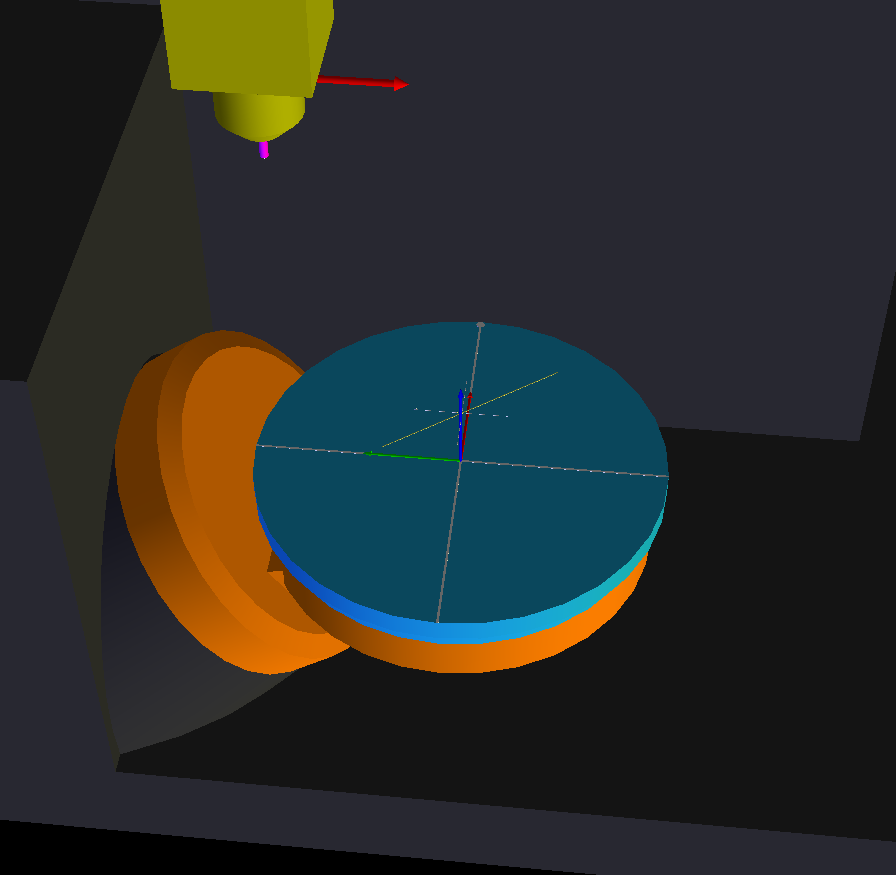

In [5]:
display(Image(filename="Images/table_90_kins.png", height=500, width=500))

We will compensate for this by subtracting the table orientation angle $\theta\mu$ from the secondary joint angle $\theta_s$ in the kinematic model.  

## Combining Table Orientation and Primary Rotation

To combine the table orientation and the primary joint rotation we multiply the primary joint rotation matrix $R_n$ from the leftt with the table orientation matrix $R_t$

In [6]:
Rp=Rn*Rt
display(Math(rf'R_p =~ R_n ~\cdot~R_t= ~~'+latex(Rn)+rf'\cdot'+latex(Rt)+rf'=~~~'+latex(Rp)))

<IPython.core.display.Math object>

In [7]:
# calculate the forward transformation matrix
qAp=Rp
display(Math(rf'^QA_P =~~'+latex(Rp)))


<IPython.core.display.Math object>

In [8]:
# calculate the forward kinematic
Q_out=qAp*P_
display(Math(rf'Q =~'+latex(Q_)+rf'=~^QA_P \cdot P=~~'+latex(qAp)+rf'\cdot'+latex(P_)+rf'=~~~'+latex(Q_out)))

<IPython.core.display.Math object>

In [9]:
# Extract the tool-position vector Q (FORWARD KINEMATICS) from
# the fourth column of the forward transformation matrix
display(Math(latex(Q_[0][0]) + rf'~=~'  + latex(Q_out[0])))
display(Math(latex(Q_[1][0]) + rf'~=~'  + latex(Q_out[1])))
display(Math(latex(Q_[2][0]) + rf'~=~'  + latex(Q_out[2])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [10]:
# expressions as used in kinematics component
print('//TCP kinematics FORWARD')
print('pos->tran.x = ', Q_out[0], ';')
print('pos->tran.y = ', Q_out[1], ';')
print('pos->tran.z = ', Q_out[2], ';')

//TCP kinematics FORWARD
pos->tran.x =  ((Cp*Cu + CvSp*Su)*Px + (Cu*CvSp - Cp*Su)*Py + Pz*SvSp) ;
pos->tran.y =  (-(Cu*CvSp - Su*r)*Px + (CvSp*Su + Cu*r)*Py + Pz*t) ;
pos->tran.z =  (-(Cu*SvSp - Su*t)*Px + (Su*SvSp + Cu*t)*Py + Pz*s) ;


### Inverse transformation

To calculate the joint position $P$ from given coordinate positions $Q$ we need to 'unrotate' the primary rotary joint. Mathematically this means we need to transpose the rotation part in our transformation matrix.

\begin{equation}
 ^PA_Q=~ R_p^T 
\end{equation}

In [11]:
# calculate the inverse transformation matrix
pAq=Rp.transpose()
display(Math(rf'^PA_Q =~~'+latex(Rp.transpose())))

<IPython.core.display.Math object>

To derive the joint position $P$ we then multiply the coordinate position vector $Q$ from the right:

\begin{equation}
 P=~^PA_Q \cdot Q
\end{equation}

In [12]:
# calculate the inverse kinematic
P_out=pAq*Q_
display(Math(rf'P =~'+latex(P_)+rf'=~^PA_Q \cdot Q=~~'+rf'=~'+latex(pAq)+rf'\cdot'+latex(Q_)+rf'=~'+latex(P_out)))

<IPython.core.display.Math object>

In [13]:
# Extract the joint-position vector P (INVERSE KINEMATICS) from
# the fourth column of the inverse transformation matrix
display(Math(latex(P_[0][0]) + rf'~=~'  + latex(P_out[0])))
display(Math(latex(P_[1][0]) + rf'~=~'  + latex(P_out[1])))
display(Math(latex(P_[2][0]) + rf'~=~'  + latex(P_out[2])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [14]:
# expressions as used in kinematics component
print('//TCP kinematics INVERSE')
print('j[0] = ', P_out[0], ';')
print('j[1] = ', P_out[1], ';')
print('j[2] = ', P_out[2], ';')

//TCP kinematics INVERSE
j[0] =  ((Cp*Cu + CvSp*Su)*Qx - (Cu*CvSp - Su*r)*Qy - (Cu*SvSp - Su*t)*Qz) ;
j[1] =  ((Cu*CvSp - Cp*Su)*Qx + (CvSp*Su + Cu*r)*Qy + (Su*SvSp + Cu*t)*Qz) ;
j[2] =  (Qx*SvSp + Qz*s + Qy*t) ;


## Table Secondary Rotation
### Forward transformation

In this case the forward transformation matrix for the secondary rotation is equal to a rotation around the z-axis:


In [15]:
# define transformation matrix for the secondary rotary (ie rotation around z-axis)
var('Cs','Ss')
Rs=matrix([[  Cs, -Ss,   0, 0],
           [  Ss,  Cs,   0, 0],
           [  0 ,  0 ,   1, 0],
           [  0,   0 ,   0, 1]])
display(Math(rf'R_s =~'+latex(Rs)))

<IPython.core.display.Math object>

with $~~Ss = sin(\theta_s),~~~ Cs = cos(\theta_s)$
Note that we need to compensate for the table orientation angle $\theta_\mu$ as discussed above!<br>
Hence $\theta_s$ being the angle of rotation around the secondary rotary joint minus the table orientation angle $\theta_\mu$

To build the forward transformation matrix $^QA_P$ for the primary and the secondary rotation we need to multipy $R_s$  with $R_p$ from the left:

\begin{equation}
 ^QA_P=~ R_s \cdot R_p 
\label{eq:trns_fwd}
\end{equation}
 

In [16]:
# calculate the forward transformation matrix
qAp=Rs*Rp
display(Math(rf'^QA_P =~~'+latex(Rs)+rf'\cdot'+latex(Rp)+rf'=~~'+latex(qAp)))


<IPython.core.display.Math object>

In [17]:
# calculate the forward kinematic
Q_out=qAp*P_
display(Math(rf'Q =~'+latex(Q_)+rf'=~^QA_P \cdot P'+rf'=~'+latex(qAp)+rf'\cdot'+latex(P_)))
display(Math(rf'Q =~'+latex(Q_)+rf'=~'+latex(Q_out)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [18]:
# Extract the tool-position vector Q (FORWARD KINEMATICS) from
# the fourth column of the forward transformation matrix
display(Math(latex(Q_[0][0]) + rf'~=~'  + latex(Q_out[0])))
display(Math(latex(Q_[1][0]) + rf'~=~'  + latex(Q_out[1])))
display(Math(latex(Q_[2][0]) + rf'~=~'  + latex(Q_out[2])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [19]:
# expressions as used in kinematics component
print('//TCP kinematics FORWARD')
print('pos->tran.x = ', Q_out[0], ';')
print('pos->tran.y = ', Q_out[1], ';')
print('pos->tran.z = ', Q_out[2], ';')

//TCP kinematics FORWARD
pos->tran.x =  (((Cp*Cu + CvSp*Su)*Cs + (Cu*CvSp - Su*r)*Ss)*Px + ((Cu*CvSp - Cp*Su)*Cs - (CvSp*Su + Cu*r)*Ss)*Py + (Cs*SvSp - Ss*t)*Pz) ;
pos->tran.y =  (-((Cu*CvSp - Su*r)*Cs - (Cp*Cu + CvSp*Su)*Ss)*Px + ((CvSp*Su + Cu*r)*Cs + (Cu*CvSp - Cp*Su)*Ss)*Py + (Ss*SvSp + Cs*t)*Pz) ;
pos->tran.z =  (-(Cu*SvSp - Su*t)*Px + (Su*SvSp + Cu*t)*Py + Pz*s) ;


### Inverse transformation

To calculate the joint position $P$ from given coordinate positions $Q$ we now need to first 'unrotate' the secondary rotary joint and then the primary joint. Mathematically this means we need to multiply $R_p^T$ with $R_s^T$ from the left .

\begin{equation}
 ^PA_Q=~ R_p^T \cdot  R_s^T
\end{equation}


In [20]:
# calculate the inverse transformation matrix
pAq=Rp.transpose()*Rs.transpose()
display(Math(rf'^PA_Q =~~'+latex(Rp.transpose())+rf'\cdot'+latex(Rs.transpose())+rf'=~'+latex(pAq)))

<IPython.core.display.Math object>

To derive the joint position $P$ we then multiply the coordinate position vector $Q$ from the right:

\begin{equation}
 P=~^PA_Q \cdot Q
\end{equation}

In [21]:
# calculate the inverse kinematic
P_out=pAq*Q_
display(Math(rf'P =~'+latex(P_)+rf'=~'+latex(pAq)+rf'\cdot'+latex(Q_)+rf'=~'+latex(P_out)))

<IPython.core.display.Math object>

In [22]:
# Extract the joint-position vector P (INVERSE KINEMATICS) from
# the fourth column of the inverse transformation matrix
display(Math(latex(P_[0][0]) + rf'~=~'  + latex(P_out[0])))
display(Math(latex(P_[1][0]) + rf'~=~'  + latex(P_out[1])))
display(Math(latex(P_[2][0]) + rf'~=~'  + latex(P_out[2])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [23]:
# expressions as used in kinematics component
print('//TCP kinematics INVERSE')
print('j[0] = ', P_out[0], ';')
print('j[1] = ', P_out[1], ';')
print('j[2] = ', P_out[2], ';')

//TCP kinematics INVERSE
j[0] =  (((Cp*Cu + CvSp*Su)*Cs + (Cu*CvSp - Su*r)*Ss)*Qx - ((Cu*CvSp - Su*r)*Cs - (Cp*Cu + CvSp*Su)*Ss)*Qy - (Cu*SvSp - Su*t)*Qz) ;
j[1] =  (((Cu*CvSp - Cp*Su)*Cs - (CvSp*Su + Cu*r)*Ss)*Qx + ((CvSp*Su + Cu*r)*Cs + (Cu*CvSp - Cp*Su)*Ss)*Qy + (Su*SvSp + Cu*t)*Qz) ;
j[2] =  ((Cs*SvSp - Ss*t)*Qx + (Ss*SvSp + Cs*t)*Qy + Qz*s) ;


## Offsets in the rotary assembly

The rotational axes of a rotary assembly like type discussed here will always have an intended or unintented offset from one rotational axis to the other. In our case this is an offset in the x direction (red indicator) and in the z direction (blue indicator). In the image the yellow rod indicates the rotational axis of B and the yellow cross at it's end indicates where the axis B and axis C intersect when both x- and z-offset are zero this is also called the 'rotation point' of the rotary assembly. In this example we define the values for the offsets in the example image as x-offset = 50 and z-offset = 250. In our kinematic model this represents the situation where, starting from the center of the face of the rotary C, we need to travel 250 in the positive z-direction and 50 in the positive x-direction to reach the rotation point of the rotary assembly.

Note that the direction of travel when defining these offsets is arbitrary so in our case the offset situation in the image could also be defined as -50 in x and -250 in z. However once the definition is made we must keep it through the entire process of building the kinematic model.

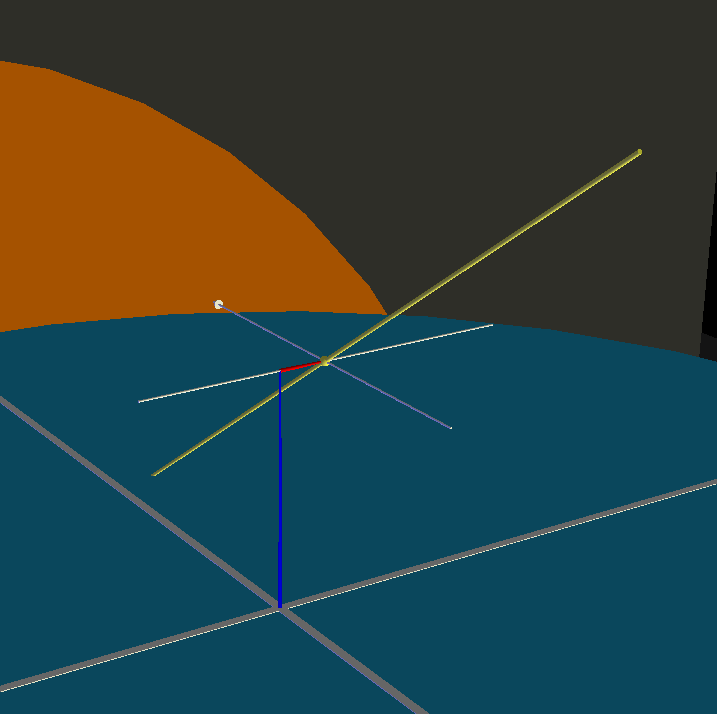

In [24]:

display(Image(filename="Images/table_dxdz.png", 
              height=500, width=500))

### Forward transformation

Because these offsets are located in between the two rotations they also need to be built in between the rotations in our transformation matrix. It may be helpful to view the offsets as the components of a vector. In our case the vector components would be (20,0,300) and the vector would point from the face of the rotary table C to the rotation point. 
To build the transformation matrix that describes these offsets we need to keep in mind whether we are moving with or against the offset vector as we travel from the work to the spindle. In our case we defined the offset vector to point away from the rotary C so we are travelling in the same direction and thus the vector components need to be entered as positive numbers.

\begin{equation}
 ^QA_P=~ R_s \cdot T_o \cdot R_p
\end{equation}

In [25]:
# define the forward transformation for the geometric offsets
var('Dx','Dz')
To=matrix([[ 1, 0, 0,  Dx],
           [ 0, 1, 0,  0 ],
           [ 0, 0, 1,  Dz],
           [ 0, 0, 0,  1 ]])
display(Math(rf'T_o =~'+latex(To)))



<IPython.core.display.Math object>

In [26]:
# calculate the forward transformation matrix
qAp=Rs*To*Rp
display(Math(rf'^QA_P =~~'+latex(Rs)+rf'\cdot'+latex(To)+rf'\cdot'+latex(Rp)+latex(qAp)))

<IPython.core.display.Math object>

In [27]:
# calculate the forward kinematic
Q_out=qAp*P_
display(Math(rf'Q =~'+latex(Q_)+rf'=~^QA_P \cdot P'+rf'=~'+latex(qAp)+rf'\cdot'+latex(P_)))
display(Math(rf'Q =~'+latex(Q_)+rf'=~'+latex(Q_out)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [28]:
# Extract the tool-position vector Q (FORWARD KINEMATICS) from
# the fourth column of the forward transformation matrix
display(Math(latex(Q_[0][0]) + rf'~=~'  + latex(Q_out[0])))
display(Math(latex(Q_[1][0]) + rf'~=~'  + latex(Q_out[1])))
display(Math(latex(Q_[2][0]) + rf'~=~'  + latex(Q_out[2])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [29]:
# expressions as used in kinematics component
print('//TCP kinematics FORWARD')
print('pos->tran.x = ', Q_out[0], ';')
print('pos->tran.y = ', Q_out[1], ';')
print('pos->tran.z = ', Q_out[2], ';')

//TCP kinematics FORWARD
pos->tran.x =  (Cs*Dx + ((Cp*Cu + CvSp*Su)*Cs + (Cu*CvSp - Su*r)*Ss)*Px + ((Cu*CvSp - Cp*Su)*Cs - (CvSp*Su + Cu*r)*Ss)*Py + (Cs*SvSp - Ss*t)*Pz) ;
pos->tran.y =  (-((Cu*CvSp - Su*r)*Cs - (Cp*Cu + CvSp*Su)*Ss)*Px + ((CvSp*Su + Cu*r)*Cs + (Cu*CvSp - Cp*Su)*Ss)*Py + (Ss*SvSp + Cs*t)*Pz + Dx*Ss) ;
pos->tran.z =  (-(Cu*SvSp - Su*t)*Px + (Su*SvSp + Cu*t)*Py + Pz*s + Dz) ;


### Inverse transformation

In the inverse transformation

\begin{equation}
 ^PA_Q=~ R_p^T \cdot  T_{io} \cdot  R_s^T
\end{equation}

Where $T_{io}$ is the inverted offset vector translation:

In [30]:
# define the inverse transformation for the geometric offsets
Tio=matrix([[ 1, 0, 0,  -Dx],
           [ 0, 1, 0,  0 ],
           [ 0, 0, 1,  -Dz],
           [ 0, 0, 0,  1 ]])
display(Math(rf'T_io =~'+latex(Tio)))

<IPython.core.display.Math object>

In [31]:
# calculate inverse transformation matrix
pAq=Rp.transpose()*Tio*Rs.transpose()
display(Math(rf'^PA_Q=~'+latex(Rp.transpose())+rf'\cdot'+latex(Tio)+rf'\cdot'+latex(Rs.transpose())+rf'=~'+latex(P_out)))

<IPython.core.display.Math object>

In [32]:
# calculate the inverse kinematic
P_out=pAq*Q_
display(Math(rf'P =~'+latex(P_)+rf'=~'+latex(pAq)+rf'\cdot'+latex(Q_)))
display(Math(rf'P =~'+latex(P_)+rf'=~'+latex(P_out)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [33]:
# Extract the joint-position vector P (INVERSE KINEMATICS) from
# the fourth column of the inverse transformation matrix
display(Math(latex(P_[0][0]) + rf'~=~'  + latex(P_out[0])))
display(Math(latex(P_[1][0]) + rf'~=~'  + latex(P_out[1])))
display(Math(latex(P_[2][0]) + rf'~=~'  + latex(P_out[2])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [34]:
# expressions as used in kinematics component
print('//TCP kinematics INVERSE')
print('j[0] = ', P_out[0], ';')
print('j[1] = ', P_out[1], ';')
print('j[2] = ', P_out[2], ';')

//TCP kinematics INVERSE
j[0] =  (-(Cp*Cu + CvSp*Su)*Dx + (Cu*SvSp - Su*t)*Dz + ((Cp*Cu + CvSp*Su)*Cs + (Cu*CvSp - Su*r)*Ss)*Qx - ((Cu*CvSp - Su*r)*Cs - (Cp*Cu + CvSp*Su)*Ss)*Qy - (Cu*SvSp - Su*t)*Qz) ;
j[1] =  (-(Cu*CvSp - Cp*Su)*Dx - (Su*SvSp + Cu*t)*Dz + ((Cu*CvSp - Cp*Su)*Cs - (CvSp*Su + Cu*r)*Ss)*Qx + ((CvSp*Su + Cu*r)*Cs + (Cu*CvSp - Cp*Su)*Ss)*Qy + (Su*SvSp + Cu*t)*Qz) ;
j[2] =  ((Cs*SvSp - Ss*t)*Qx + (Ss*SvSp + Cs*t)*Qy - Dx*SvSp - Dz*s + Qz*s) ;


Note that our machine reference point has now shifted from the rotation point of the table rotary assembly along the offsets to the center of the rotary table which is fine for this example.

-------

## Excursion: Shifting the reference point back to the rotation point

If we wanted the machine reference to remain in the rotation point we would need to add another link to the kinematic chain:<br>

### Forward kinematic
We set $P=(Px,Py,Pz)=(0,0,0)$ <br>
and $\theta_p = \theta_s = 0$ which gives $Sp=Ss=0,~ Cp=Cs=1,~ t=0,~ r=s=1$<br>
With these input values our current forward kinematic

In [35]:
display(Math(rf'Q =~'+latex(Q_)+rf'=~'+latex(Q_out)))

<IPython.core.display.Math object>

results in $Q(Dx,0,Dz)$ 
Which is the reason our machine reference point has been moved to the face center of the rotary C. So in order to move the machine reference back to the rotation-point of the rotary assembly we need to add the offset values $(-Dx,-Dz)$ to the result of our forward kinematic which we can do in the form of a vector translation by $T_{io}$ 

that is multiplied with our forward transformation matrix from the left.


\begin{equation}
 ^QA_P=~ T_io \cdot R_s \cdot T_o \cdot R_p
\end{equation}

In [36]:
# calculate the forward transformation matrix
qAp=Tio*Rs*To*Rp
display(Math(rf'^QA_P =~~'+latex(Tio)+rf'\cdot'+latex(Rs)+rf'\cdot'+latex(To)+rf'\cdot'+latex(Rp)))
display(Math(rf'^QA_P =~~'+latex(qAp)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [37]:
# calculate the forward kinematic
Q_out=qAp*P_
display(Math(rf'Q =~'+latex(Q_)+rf'=~^QA_P \cdot P'+rf'=~'+latex(qAp)+rf'\cdot'+latex(P_)+rf'=~'+latex(Q_out)))

<IPython.core.display.Math object>

In [38]:
# Extract the tool-position vector Q (FORWARD KINEMATICS) from
# the fourth column of the forward transformation matrix
display(Math(latex(Q_[0][0]) + rf'~=~'  + latex(Q_out[0])))
display(Math(latex(Q_[1][0]) + rf'~=~'  + latex(Q_out[1])))
display(Math(latex(Q_[2][0]) + rf'~=~'  + latex(Q_out[2])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [39]:
# expressions as used in kinematics component
print('//TCP kinematics FORWARD')
print('pos->tran.x = ', Q_out[0], ';')
print('pos->tran.y = ', Q_out[1], ';')
print('pos->tran.z = ', Q_out[2], ';')

//TCP kinematics FORWARD
pos->tran.x =  (Cs*Dx + ((Cp*Cu + CvSp*Su)*Cs + (Cu*CvSp - Su*r)*Ss)*Px + ((Cu*CvSp - Cp*Su)*Cs - (CvSp*Su + Cu*r)*Ss)*Py + (Cs*SvSp - Ss*t)*Pz - Dx) ;
pos->tran.y =  (-((Cu*CvSp - Su*r)*Cs - (Cp*Cu + CvSp*Su)*Ss)*Px + ((CvSp*Su + Cu*r)*Cs + (Cu*CvSp - Cp*Su)*Ss)*Py + (Ss*SvSp + Cs*t)*Pz + Dx*Ss) ;
pos->tran.z =  (-(Cu*SvSp - Su*t)*Px + (Su*SvSp + Cu*t)*Py + Pz*s) ;


### Inverse transformation

In the inverse transformation

\begin{equation}
 P=~^PA_Q \cdot Q =~ R_p^T\cdot  T_{io} \cdot  R_s^T \cdot Q 
\end{equation}

 we have to add the offset values $Dx,Dz$ to the input values $Q$:

In [40]:
var('Qx','Qy','Qz')
Q_in=matrix([[Qx+Dx],
             [Qy],
             [Qz+Dz],
             [1]])
display(Math(rf'Q =~'+latex(Q_in)))

<IPython.core.display.Math object>

This is essentially the same as multiplying a translation vector to right side of our transformation matrix. To keep the math more readable we choose to subtract the values directly from the input.

In [41]:
# nothing has changed in the inverse transformation matrix
display(Math(rf'^PA_Q =~~'+latex(pAq)))

<IPython.core.display.Math object>

In [42]:
# calculate the inverse kinematic
P_out=pAq*Q_in
display(Math(rf'P =~'+latex(P_)+rf'=~'+latex(pAq)+rf'\cdot'+latex(Q_in)))
display(Math(rf'P =~'+latex(P_)+rf'=~'+latex(P_out)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [43]:
# Extract the joint-position vector P (INVERSE KINEMATICS) from
# the fourth column of the inverse transformation matrix
display(Math(latex(P_[0][0]) + rf'~=~'  + latex(P_out[0])))
display(Math(latex(P_[1][0]) + rf'~=~'  + latex(P_out[1])))
display(Math(latex(P_[2][0]) + rf'~=~'  + latex(P_out[2])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [44]:
# expressions as used in kinematics component
print('//TCP kinematics INVERSE')
print('j[0] = ', P_out[0], ';')
print('j[1] = ', P_out[1], ';')
print('j[2] = ', P_out[2], ';')

//TCP kinematics INVERSE
j[0] =  (((Cp*Cu + CvSp*Su)*Cs + (Cu*CvSp - Su*r)*Ss)*(Dx + Qx) - (Cp*Cu + CvSp*Su)*Dx - (Cu*SvSp - Su*t)*(Dz + Qz) + (Cu*SvSp - Su*t)*Dz - ((Cu*CvSp - Su*r)*Cs - (Cp*Cu + CvSp*Su)*Ss)*Qy) ;
j[1] =  (((Cu*CvSp - Cp*Su)*Cs - (CvSp*Su + Cu*r)*Ss)*(Dx + Qx) - (Cu*CvSp - Cp*Su)*Dx + (Su*SvSp + Cu*t)*(Dz + Qz) - (Su*SvSp + Cu*t)*Dz + ((CvSp*Su + Cu*r)*Cs + (Cu*CvSp - Cp*Su)*Ss)*Qy) ;
j[2] =  ((Cs*SvSp - Ss*t)*(Dx + Qx) + (Ss*SvSp + Cs*t)*Qy - Dx*SvSp + (Dz + Qz)*s - Dz*s) ;


## End of Excursion

-----

## Tool length offset (TLO)

Tool-length compensation is applied automatically in LinuxCNC by subtracting the tool-length value *Dt* stored in the tool table from the the z-axis coordinate position while the joint position value remains unchanged. In it's current form our forward kinematic model assumes that the joint position $P$ is identical to the tool position and uses the joint position value $P(Px,Py,Pz)$ to calculate the coordinate value $Q(Qx,Qy,Qz)$. Hence our kinematic model does not see a tool position change when TLO is activated by G43.


### Forward kinematics

To illustrate the situation we assume that the machine coordinate system origin (ie G53 X0Y0Z0) coincides with the rotation point of our rotary assembly. Further assuming that a tool could be positioned in this location we would expect that without any tool-length compensation (G49) a tool positioned here (G0 X0Y0Z0) would be unaffected by any rotation of either B or C and that is indeed the case:

In [45]:
display(Math(rf'Q =~'+latex(Q_)+rf'=~'+latex(Q_out)))

<IPython.core.display.Math object>

It is easy to see that for $Dx=Dz=0$ and $P(0,0,0)$ the result is indeed $Q(0,0,0)$ and this is what we expected.

However there is a problem: <br>
If we apply tool-length compensation (ie G43) and we move the tool to G0 X0Y0Z0  so the tool center point (TCP) is again positioned at the machine reference point our DRO would no longer display the expected coordinates (0,0,0). Since our tool tip is now located in the machine reference point and due to the way TLO is handled by LinuxCNC our joint-position is now $P(0,0,Dt)$. As $P_z$ is no longer zero our forward kinematic will result in $Q(0,0,sP_z)$.<br>
To solve this problem we need to subtract the tool-offset value *Dt* from the z joint position before feeding it into the forward kinematic. In this way our joint-position becomes $P(0,0,0)$ which will then give us the desired result of $Q(0,0,0)$. <br>

In [46]:
var('Px','Py','Pz','Dt')
P_in=matrix([[Px],
             [Py],
             [Pz - Dt],
             [1]])
display(Math(rf'P =~'+latex(P_in)))

<IPython.core.display.Math object>

In [47]:
# calculate forward kinematic
Q_out=qAp*P_in
display(Math(rf'Q =~'+latex(Q_)+rf'=~^QA_P \cdot P'+rf'=~'+latex(qAp)+rf'\cdot'+latex(P_in)))
display(Math(rf'Q =~'+latex(Q_out)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Alas, if we were to test this in LinuxCNC the DRO would now show a z-axis position value equivalent to *-Dt* instead of the expected *0.000*. This is because LinuxCNC automatically subtracts the TLO value from the value of *pos->tran.z* which is the result of our forward kinematic.<br>
This can be fixed by adding *Dt* back to the result of our forward kinematic calculation which we can do by creating a vector translation:


In [48]:
Tt=matrix([[ 1, 0, 0, 0],
           [ 0, 1, 0, 0],
           [ 0, 0, 1, Dt],
           [ 0, 0, 0, 1 ]])

display(Math(rf'Tt=~'+latex(Tt)))

<IPython.core.display.Math object>

and multiply that to the left of our transformation matrix:


\begin{equation}
 ^QA_P=~ T_t \cdot R_s \cdot T_o \cdot R_p
\end{equation}

In [49]:
# calculate the forward transformation matrix
qAp=Tt*Rs*To*Rp
display(Math(rf'^QA_P =~~'+latex(Tt)+rf'\cdot'+latex(Rs)+rf'\cdot'+latex(To)+rf'\cdot'+latex(Rp)))
display(Math(rf'^QA_P =~~'+latex(qAp)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [50]:
# calculate forward kinematic
Q_out=qAp*P_in
display(Math(rf'Q =~'+latex(Q_)+rf'=~^QA_P \cdot P=~'+latex(qAp)+rf'\cdot'+latex(P_in)))
display(Math(rf'Q =~'+latex(Q_out)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [51]:
# Extract the tool-position vector Q (FORWARD KINEMATICS) from
# the fourth column of the forward transformation matrix
display(Math(latex(Q_[0][0]) + rf'~=~'  + latex(Q_out[0])))
display(Math(latex(Q_[1][0]) + rf'~=~'  + latex(Q_out[1])))
display(Math(latex(Q_[2][0]) + rf'~=~'  + latex(Q_out[2])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [52]:
# expressions as used in kinematics component
print('//TCP kinematics FORWARD')
print('pos->tran.x = ', Q_out[0], ';')
print('pos->tran.y = ', Q_out[1], ';')
print('pos->tran.z = ', Q_out[2], ';')

//TCP kinematics FORWARD
pos->tran.x =  (-(Cs*SvSp - Ss*t)*(Dt - Pz) + Cs*Dx + ((Cp*Cu + CvSp*Su)*Cs + (Cu*CvSp - Su*r)*Ss)*Px + ((Cu*CvSp - Cp*Su)*Cs - (CvSp*Su + Cu*r)*Ss)*Py) ;
pos->tran.y =  (-(Ss*SvSp + Cs*t)*(Dt - Pz) - ((Cu*CvSp - Su*r)*Cs - (Cp*Cu + CvSp*Su)*Ss)*Px + ((CvSp*Su + Cu*r)*Cs + (Cu*CvSp - Cp*Su)*Ss)*Py + Dx*Ss) ;
pos->tran.z =  (-(Cu*SvSp - Su*t)*Px + (Su*SvSp + Cu*t)*Py - (Dt - Pz)*s + Dt + Dz) ;


### Inverse transformation

For the inverse transformation to match the new forward transformation we need to subtract $Dt$ from the coordinate position $Q$ and add it back to the result which we do by multiplying the translation by the vector $Dt$ from the left:

\begin{equation}
 P=~^PA_Q \cdot Q =~ R_t \cdot R_p^T \cdot  T_{io} \cdot  R_s^T \cdot Q 
\end{equation}


In [53]:
var('Qx','Qy','Qz')
Q_in=matrix([[Qx],
             [Qy],
             [Qz-Dt],
             [1]])
display(Math(rf'Q =~'+latex(Q_in)))


<IPython.core.display.Math object>

In [54]:
# calculate the inverse transformation matrix
pAq=Tt*Rp.transpose()*Tio*Rs.transpose()
display(Math(rf'^PA_Q =~~'+latex(Tt)+rf'\cdot'+latex(Rp.transpose())+rf'\cdot'+latex(Tio)+rf'\cdot'+latex(Rs.transpose())))
display(Math(rf'^PA_Q =~~'+latex(pAq)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [55]:
P_out=pAq*Q_in
display(Math(rf'P =~'+latex(P_)+rf'=~^PA_Q \cdot Q=~'+latex(pAq)+rf'\cdot'+latex(Q_in)))
display(Math(rf'P =~'+latex(P_out)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [56]:
# Extract the joint-position vector P (INVERSE KINEMATICS) from
# the fourth column of the inverse transformation matrix
display(Math(latex(P_[0][0]) + rf'~=~'  + latex(P_out[0])))
display(Math(latex(P_[1][0]) + rf'~=~'  + latex(P_out[1])))
display(Math(latex(P_[2][0]) + rf'~=~'  + latex(P_out[2])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [57]:
# expressions as used in kinematics component
print('//TCP kinematics INVERSE')
print('j[0] = ', P_out[0], ';')
print('j[1] = ', P_out[1], ';')
print('j[2] = ', P_out[2], ';')

//TCP kinematics INVERSE
j[0] =  ((Cu*SvSp - Su*t)*(Dt - Qz) - (Cp*Cu + CvSp*Su)*Dx + (Cu*SvSp - Su*t)*Dz + ((Cp*Cu + CvSp*Su)*Cs + (Cu*CvSp - Su*r)*Ss)*Qx - ((Cu*CvSp - Su*r)*Cs - (Cp*Cu + CvSp*Su)*Ss)*Qy) ;
j[1] =  (-(Su*SvSp + Cu*t)*(Dt - Qz) - (Cu*CvSp - Cp*Su)*Dx - (Su*SvSp + Cu*t)*Dz + ((Cu*CvSp - Cp*Su)*Cs - (CvSp*Su + Cu*r)*Ss)*Qx + ((CvSp*Su + Cu*r)*Cs + (Cu*CvSp - Cp*Su)*Ss)*Qy) ;
j[2] =  ((Cs*SvSp - Ss*t)*Qx + (Ss*SvSp + Cs*t)*Qy - Dx*SvSp - (Dt - Qz)*s - Dz*s + Dt) ;


If our machine is setup so that the machine reference point coincides with the rotation point of our rotary-assembly then our forward kinematic is complete. Otherwise one more step is necessary to derive a correct kinematic model.

## Position offset of the rotary assembly to the machine reference point
 
Up to this point we have assumed that the machine reference point coincides with the rotation point of our rotary-assembly or in case of applied geometric offsets $(Dx, Dz)$ maybe the center of the face of our secondary rotary table. For such a case our forward kinematic is complete.
However, if the machine at hand is setup in a way where there is an offset between the machine reference point and the rotary-assembly then this will need to be taken into account in the kinematic model.<br>
What does such an offset mean for our forward kinematic? 

### Forward kinematic

Let us assume that we have a setup with no TLO ($Dt=0$), no geometric offset ($Dz=Dx=0$) and no offset of the reference-point. A tool positioned at the rotation-point (or in our case the center of the rotary table C) would have a joint-position of $P(0,0,0)$ and that would give the expected resulting coordinate position of $Q(0,0,0)$. If we now assume that the rotation-point of our rotary-assembly is offset from the machine reference point by $(rp_x,rp_y,rp_z)$ then our joint-position would be equal to the offset $P(rp_x,rp_y,rp_z)$ which would clearly not give us the required result of Q(0,0,0).<br>
So we need to subtract the offset $(rp_x,rp_y,rp_z)$ from the joint-position $P=(Px-rp_x, Py-rp_y, Pz-rp_z)$  or in other words we need to translate the joint-position vector in the opposite direction along the offset vector. 

In [58]:
var('Px','Py','Pz','Drpx','Drpy','Drpz')
P_in=matrix([[Px-Drpx],
             [Py-Drpy],
             [Pz-Drpz-Dt],
             [1]])

display(Math(rf'P =~'+latex(P_in)))

<IPython.core.display.Math object>

However some more consideration is needed for now a joint position of $P(rp_x,rp_y,rp_z)$ will result in a coordinate position of $Q(0,0,0)$ which is of course not the value we can hand back to LinuxCNC because if the rotation point is offset from machine zero then the coordinate position would be $Q(rp_x,rp_y,rp_z)$.<br> 
So to be consistent we need to add the offset values back to the results of our calculations which we do again by multiplying a vector translation to the left of our forward kinematic:

\begin{equation}
 ^QA_P=~ T_{rp} \cdot T_t \cdot R_s \cdot T_o \cdot R_p
\end{equation}

In [59]:
Trp=matrix([[ 1, 0, 0, Drpx],
            [ 0, 1, 0, Drpy],
            [ 0, 0, 1, Drpz],
            [ 0, 0, 0,  1  ]])
display(Math(rf'Trp =~'+latex(Trp)))

<IPython.core.display.Math object>

In [60]:
# calculate the forward transformation matrix
qAp=Trp*Tt*Rs*To*Rp
display(Math(rf'^QA_P =~~'+latex(Trp)+rf'\cdot'+latex(Tt)+rf'\cdot'+latex(Rs)+rf'\cdot'+latex(To)+rf'\cdot'+latex(Rp)))
display(Math(rf'^QA_P =~~'+latex(qAp)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [61]:
Q_out=qAp*P_in
display(Math(rf'Q =~'+latex(Q_)+rf'=~ ^QA_P \cdot P'))
display(Math(rf'Q =~'+latex(Q_)+rf'=~'+latex(qAp)+rf'\cdot'+latex(P_in)))
display(Math(rf'Q =~'+latex(Q_out)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [62]:
# Extract the tool-position vector Q (FORWARD KINEMATICS) from
# the fourth column of the forward transformation matrix
display(Math(latex(Q_[0][0]) + rf'~=~'  + latex(Q_out[0])))
display(Math(latex(Q_[1][0]) + rf'~=~'  + latex(Q_out[1])))
display(Math(latex(Q_[2][0]) + rf'~=~'  + latex(Q_out[2])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [63]:
# expressions as used in kinematics component
print('//TCP kinematics FORWARD')
print('pos->tran.x = ', Q_out[0], ';')
print('pos->tran.y = ', Q_out[1], ';')
print('pos->tran.z = ', Q_out[2], ';')

//TCP kinematics FORWARD
pos->tran.x =  (-((Cp*Cu + CvSp*Su)*Cs + (Cu*CvSp - Su*r)*Ss)*(Drpx - Px) - ((Cu*CvSp - Cp*Su)*Cs - (CvSp*Su + Cu*r)*Ss)*(Drpy - Py) - (Cs*SvSp - Ss*t)*(Drpz + Dt - Pz) + Cs*Dx + Drpx) ;
pos->tran.y =  (((Cu*CvSp - Su*r)*Cs - (Cp*Cu + CvSp*Su)*Ss)*(Drpx - Px) - ((CvSp*Su + Cu*r)*Cs + (Cu*CvSp - Cp*Su)*Ss)*(Drpy - Py) - (Ss*SvSp + Cs*t)*(Drpz + Dt - Pz) + Dx*Ss + Drpy) ;
pos->tran.z =  ((Cu*SvSp - Su*t)*(Drpx - Px) - (Su*SvSp + Cu*t)*(Drpy - Py) - (Drpz + Dt - Pz)*s + Drpz + Dt + Dz) ;


### Inverse transformation

For the inverse transformation to match the new forward transformation we need mirror the modifications in the forward kinematics. That means to subtract $Drp(x,y,z)$ from the coordinate position $Q$

In [64]:
var('Qx','Qy','Qz')
Q_in=matrix([[Qx-Drpx],
             [Qy-Drpy],
             [Qz-Drpz-Dt],
             [1]])
display(Math(rf'Q =~'+latex(Q_in)))

<IPython.core.display.Math object>

 and add it back to the result which we do by multiplying the translation vector $Drp(x,y,z)$ to the inverse transformation from the left:


\begin{equation}
^PA_Q =~T_{rp} \cdot~ T_t \cdot R_p^T \cdot  T_{io} \cdot  R_s^T 
\end{equation}

In [65]:
# calculate the inverse transformation matrix
pAq=Trp*Tt*Rp.transpose()*Tio*Rs.transpose()
display(Math(rf'^PA_Q =~~'+latex(Trp)+rf'\cdot'+latex(Tt)+rf'\cdot'+latex(Rp.transpose())+rf'\cdot'+latex(Tio)+rf'\cdot'+latex(Rs.transpose())))
display(Math(rf'^PA_Q =~~'+latex(pAq)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [66]:
P_out=pAq*Q_in
display(Math(rf'P =~'+latex(P_)+rf'=~^PA_Q \cdot Q'))
display(Math(rf'P =~'+latex(P_)+rf'=~'+latex(pAq)+rf'\cdot'+latex(Q_in)))
display(Math(rf'P =~'+latex(P_out)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [67]:
# Extract the joint-position vector P (INVERSE KINEMATICS) from
# the fourth column of the inverse transformation matrix
display(Math(latex(P_[0][0]) + rf'~=~'  + latex(P_out[0])))
display(Math(latex(P_[1][0]) + rf'~=~'  + latex(P_out[1])))
display(Math(latex(P_[2][0]) + rf'~=~'  + latex(P_out[2])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [68]:
# expressions as used in kinematics component
print('//TCP kinematics INVERSE')
print('j[0] = ', P_out[0], ';')
print('j[1] = ', P_out[1], ';')
print('j[2] = ', P_out[2], ';')

//TCP kinematics INVERSE
j[0] =  (-((Cp*Cu + CvSp*Su)*Cs + (Cu*CvSp - Su*r)*Ss)*(Drpx - Qx) + ((Cu*CvSp - Su*r)*Cs - (Cp*Cu + CvSp*Su)*Ss)*(Drpy - Qy) + (Cu*SvSp - Su*t)*(Drpz + Dt - Qz) - (Cp*Cu + CvSp*Su)*Dx + (Cu*SvSp - Su*t)*Dz + Drpx) ;
j[1] =  (-((Cu*CvSp - Cp*Su)*Cs - (CvSp*Su + Cu*r)*Ss)*(Drpx - Qx) - ((CvSp*Su + Cu*r)*Cs + (Cu*CvSp - Cp*Su)*Ss)*(Drpy - Qy) - (Su*SvSp + Cu*t)*(Drpz + Dt - Qz) - (Cu*CvSp - Cp*Su)*Dx - (Su*SvSp + Cu*t)*Dz + Drpy) ;
j[2] =  (-(Cs*SvSp - Ss*t)*(Drpx - Qx) - (Ss*SvSp + Cs*t)*(Drpy - Qy) - Dx*SvSp - (Drpz + Dt - Qz)*s - Dz*s + Drpz + Dt) ;


In [69]:
var('Qx','Qy','Qz')
Q_in=matrix([[Qx-Drpx],
             [Qy-Drpy],
             [Qz-Drpz-Dt],
             [1]])
display(Math(rf'Q =~'+latex(Q_in)))

<IPython.core.display.Math object>

 and add it back to the result which we do by multiplying the translation vector $Drp(x,y,z)$ to the inverse transformation from the left:


\begin{equation}
^PA_Q =~T_{rp} \cdot~ T_t \cdot R_p^T \cdot  T_{io} \cdot  R_s^T 
\end{equation}

In [70]:
# calculate the inverse transformation matrix
pAq=Trp*Tt*Rp.transpose()*Tio*Rs.transpose()
display(Math(rf'^PA_Q =~~'+latex(Trp)+rf'\cdot'+latex(Tt)+rf'\cdot'+latex(Rp.transpose())+rf'\cdot'+latex(Tio)+rf'\cdot'+latex(Rs.transpose())))
display(Math(rf'^PA_Q =~~'+latex(pAq)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [71]:
P_out=pAq*Q_in
display(Math(rf'P =~'+latex(P_)+rf'=~^PA_Q \cdot Q'))
display(Math(rf'P =~'+latex(P_)+rf'=~'+latex(pAq)+rf'\cdot'+latex(Q_in)))
display(Math(rf'P =~'+latex(P_out)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [72]:
# Extract the joint-position vector P (INVERSE KINEMATICS) from
# the fourth column of the inverse transformation matrix
display(Math(latex(P_[0][0]) + rf'~=~'  + latex(P_out[0])))
display(Math(latex(P_[1][0]) + rf'~=~'  + latex(P_out[1])))
display(Math(latex(P_[2][0]) + rf'~=~'  + latex(P_out[2])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [73]:
# expressions as used in kinematics component
print('//TCP kinematics INVERSE')
print('j[0] = ', P_out[0], ';')
print('j[1] = ', P_out[1], ';')
print('j[2] = ', P_out[2], ';')

//TCP kinematics INVERSE
j[0] =  (-((Cp*Cu + CvSp*Su)*Cs + (Cu*CvSp - Su*r)*Ss)*(Drpx - Qx) + ((Cu*CvSp - Su*r)*Cs - (Cp*Cu + CvSp*Su)*Ss)*(Drpy - Qy) + (Cu*SvSp - Su*t)*(Drpz + Dt - Qz) - (Cp*Cu + CvSp*Su)*Dx + (Cu*SvSp - Su*t)*Dz + Drpx) ;
j[1] =  (-((Cu*CvSp - Cp*Su)*Cs - (CvSp*Su + Cu*r)*Ss)*(Drpx - Qx) - ((CvSp*Su + Cu*r)*Cs + (Cu*CvSp - Cp*Su)*Ss)*(Drpy - Qy) - (Su*SvSp + Cu*t)*(Drpz + Dt - Qz) - (Cu*CvSp - Cp*Su)*Dx - (Su*SvSp + Cu*t)*Dz + Drpy) ;
j[2] =  (-(Cs*SvSp - Ss*t)*(Drpx - Qx) - (Ss*SvSp + Cs*t)*(Drpy - Qy) - Dx*SvSp - (Drpz + Dt - Qz)*s - Dz*s + Drpz + Dt) ;


This completes the kinematic model.<br>

# 'Tilted Work Plane' (TWP)

Commercial 5-axis machine controllers offer built in functionality that allow the operator to define work plane orientation using Gcode commands like G68.2 or similar. With the new custom TOOL kinematic we can now explore a possible implementation of TWP in LinuxCNC.<br>
For the purpose of this example we choose the already mentioned 'G68.2' and the associated Gcodes as used by Fanuc:<br>

* G68.2 - Set custom coordinate system using five different modes
* G68.3 - Set custom coordinate system using current tool orientation
* G68.4 - Same as 68.2 but as an incremental reorientation of an existing TWP

* G53.1 - Orient the tool to the TWP using non-TCP joint rotation 
* G53.6 - Orient the tool to the TWP using TCP joint rotation

* G69 - Cancel the TWP setting

The TWP feature always requires a TWP-definition (G68.x) before an orientation command (G53.x) can be issued.<br> 
G68.x commands do not cause any machine movement while G53 command will cause immediate machine movement.
At the end of a TWP operation a G69 command is used to return to machine coordinates.<br>

In this presentation we use a 'Pure Python Remap' to make the above Gcode commands available to the machine operator. As a consequence our depth of integration is quite limited in the sense that the LinuxCNC Gcode interpreter will be totally ignorant of our 'TWP'-mode.

## Calculating the spindle rotary joint positions for a given tool-orientation vector


The transformation matrix we derived for the inverse tool kinematic contains a rotation matrix that describes the rotation of the unit vectors of the machine coordinate system (MCS)


\begin{equation}
U ~=~
\left(\begin{array}{rrrr}
  1, 0, 0 \\
  0, 1, 0 \\
  0, 0, 1 \\
\end{array}\right)
~
Unitvectors~of~the~MCS
\end{equation}

to the tool coordinate system (TCS).


\begin{equation}
K ~=~
\left(\begin{array}{rrrr}
  Kx_x, Ky_x, Kz_x \\
  Kx_y, Ky_y, Kz_y \\
  Kx_z, Ky_z, Kz_z \\
\end{array}\right)
~
Toolvector
\end{equation}

To orient the tool perpendicular to the TWP requested by the user we need to find the angles of the spindle rotary joints so that the resulting tool-z vector matches the twp-z vector.

First we extract the tool-z vector from the third column of the transformation matrix in the inverse tool kinematic

In [74]:
# Tool-z orientation vector K 
var('Kz_x','Kz_y','Kz_z')
Kz_=matrix([[Kz_x],
          [Kz_y],
          [Kz_z],
          [1]])
# Tool-x orientation vector J 
var('Kx_x','Kx_y','Kx_z')
Kx_=matrix([[Kx_x],
          [Kx_y],
          [Kx_z],
          [1]])

In [75]:
# Extract the tool-z orientation vector from
# the third column of the forward transformation matrix
display(Math(latex(Kz_[0][0]) + rf'~=~'  + latex(qAp[0][2])))
display(Math(latex(Kz_[1][0]) + rf'~=~'  + latex(qAp[1][2])))
display(Math(latex(Kz_[2][0]) + rf'~=~'  + latex(qAp[2][2])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

With our substitutions:
$$ C_p + S²_{\nu}(1-C_p)~=~ r   ~~~~~~~~  C_p + C²_{\nu}(1-C_p) ~=~ s ~~~~~~~~ -S_{\nu}C_{\nu}(1-C_p) ~=~ t  $$ 

### Calculating the primary angle $\theta_p$
$$ Kz_z =  C_p + C²_{\nu}(1-C_p)  $$
$$ Kz_z =  C²_{\nu} + C_p - C²_{\nu}C_p  $$
$$ Kz_z =  C²_{\nu} + C_p(1 - C²_{\nu})  $$

$$ C_p = {{Kz_z - C²_{\nu}} \over {1-C²_{\nu}}} ~~ ;{\theta_{\nu}} \neq 0$$
Note that for  $\theta_{\nu} = 0$ the primary rotary axis is parallel to the secondary rotary axis which is of no interest in our case.  

$$ \theta_p = \pm acos({{Kz_z - C²_{\nu}} \over {1-C²_{\nu}}}) $$

Note that the formula above is undefined for $$ |{{Kz_z - C²_{\nu}} \over {1-C²_{\nu}}}| > 1 $$ 

First we check the positive case first
$$ {{Kz_z - C²_{\nu}} \over {1-C²_{\nu}}} > 1 $$ 
$$ {Kz_z - C²_{\nu}} > {1-C²_{\nu}} $$
We get for the upper bound 
$$ Kz_z > 1 $$ 
This case will never occur since we use a normalized vector.


Then we check the negative case
$$ {{Kz_z - C²_{\nu}} \over {1-C²_{\nu}}} < -1 $$
$$ {Kz_z - C²_{\nu}} < {C²_{\nu}-1} $$
We get for the lower bound
$$ Kz_z  < {2C²_{\nu}-1} $$
Which tells us that the lower bound for our $Kz_z$ value depends on the nutation angle $\theta_\nu$.
<br>
For $\theta_\nu = 90°$ the above collapses to 
$$ Kz_z  < -1 $$
Which will also never occur for a normalized vector. 

For $\theta_\nu = 0°$ the above collapses to 
$$ Kz_z  < 1 $$
Which is always true. 
Note that this is the case when the primary rotary axis is parallel to the secondary and it is intuitive that we cannot rotate the $Kz$ vector out of the vertical at all.<br>
In other words we can rotate our table to a maximum of $2\theta\nu$ out of the vertical position.  


### Calculating the secondary angle $\theta_s$

$$ Kz_y =  S_sS_{\nu}S_p + tC_s  $$

Note that this expression is of the form 
$$aCos\theta_s ~+~ bSin\theta_s = c$$

with 

$$a = t$$
$$b = S_{\nu}S_p$$
$$c = Kz_y$$

However we first substitute:

$$a = RCos\phi, ~~~b = RSin\phi$$

and note that

$$ a²+b² = R²Cos²\phi ~+~ R²Sin²\phi$$
$$ a²+b² = R²~~(Cos²\phi ~+~ Sin²\phi)$$
$$ a²+b² = R²$$
and hence 
$$R=\sqrt{a²+b²}$$

we also note that
$${a \over b} = { {RCos\phi} \over {RSin\phi}}$$
and thus
$$ tan\phi = {a \over b} ~~ ;b = S_{\nu}S_p\neq 0 \rightarrow {\theta_{\nu}} \neq 0,  {\theta_{p}} \neq 0$$
Note that the case of $\theta_{\nu} = 0$ was already disussed above but the case of ${\theta_{p}} = 0$ will need to be examined later.  

Further we note that 
$$  RCos\phi~ Cos\theta_s ~+~ RSin\phi~ Sin\theta_s = c $$
$$  R~(Cos\phi Cos\theta_s ~+~ Sin\phi Sin\theta_s) = c $$
and using the cosine summation formula
$$  R~(Cos\phi Cos\theta_s ~+~ Sin\phi Sin\theta_s) = RCos(\phi - \theta_s) $$
we see that 
$$ c = RCos(\phi - \theta_s) $$

Hence we can calculate 

$$\phi - \theta_s = {\pm acos({c \over{R}})}   ~~,R = \sqrt{a²+b²} \neq 0, ~|{c \over{R}}|<1$$  
$$ \theta_s = {\pm acos({c \over {R}})} -\phi $$  

And finally

$$ \theta_s = {\pm acos({c \over {\sqrt{a²+b²}}}) - atan({a \over b})}~~~~~~~ with~  a = t,~b = S_{\nu}S_p,~c = Kz_y$$


Handling the case of  ${\theta_{p}} = 0$:

If the primary angle is zero the machine table is horizontal and thus $Kz = (0,0,1)^T$ in this case we can calculate  ${\theta_{s}}$ from $Kx$:

In [76]:
# Extract the tool-x orientation vector from
# the first column of the inverse transformation matrix
display(Math(latex(Kx_[0][0]) + rf'~=~'  + latex(pAq[0][0])))
display(Math(latex(Kx_[1][0]) + rf'~=~'  + latex(pAq[1][0])))
display(Math(latex(Kx_[2][0]) + rf'~=~'  + latex(pAq[2][0])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

$${\theta_{s}} = atan({Kx_y \over Kx_x})   ~~ Kx_x \neq 0$$


## TWP kinematics

For kinematics with only work side rotations the oriented work plane will always be horizontal thus the only difference to a trivial kinematic will be a possible offset in the origin of the work coordinate system (WCS) and a possible vertical rotation of the WCS around the Z axis. Both of these could be handled by changing the current work offset XYZ and R values.<br>
For our example we opt to handle the rotation around the Z axis in a separate kinematic instead.


### Forward kinematics
We need to compensate for cases where the machine reference point is not identical to the center face of the rotary table. This is done in the same manner as already discussed in the TCP kinematic above.


In [77]:
var('Px','Py','Pz','Drpx','Drpy','Drpz')
P_in=matrix([[Px-Drpx],
             [Py-Drpy],
             [Pz-Drpz],
             [1]])

display(Math(rf'P =~'+latex(P_in)))

<IPython.core.display.Math object>

The only other part in our kinematic chaine is the rotation around the Z-axis $R_wc$

\begin{equation}
 ^QA_P=~ T_{rp} \cdot R_wc
\end{equation}

In [78]:
var('Swc','Cwc')
Rwc=matrix([[ Cwc, -Swc, 0, 0],
            [ Swc,  Cwc, 0, 0],
            [ 0 ,  0 ,   1, 0],
            [ 0,   0 ,   0, 1]])

display(Math(rf'R_wc=~'+latex(Rwc)))

<IPython.core.display.Math object>

In [79]:
# calculate the forward transformation matrix
qAp=Trp*Rwc
display(Math(rf'^QA_P =~~'+latex(Trp)+rf'\cdot'+latex(Rwc)))
display(Math(rf'^QA_P =~~'+latex(qAp)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [80]:
Q_out=qAp*P_in
display(Math(rf'Q =~'+latex(Q_)+rf'=~ ^QA_P \cdot P'))
display(Math(rf'Q =~'+latex(Q_)+rf'=~'+latex(qAp)+rf'\cdot'+latex(P_in)))
display(Math(rf'Q =~'+latex(Q_out)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [81]:
# Extract the tool-position vector Q (FORWARD KINEMATICS) from
# the fourth column of the forward transformation matrix
display(Math(latex(Q_[0][0]) + rf'~=~'  + latex(Q_out[0])))
display(Math(latex(Q_[1][0]) + rf'~=~'  + latex(Q_out[1])))
display(Math(latex(Q_[2][0]) + rf'~=~'  + latex(Q_out[2])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [82]:
# expressions as used in kinematics component
print('//TCP kinematics FORWARD')
print('pos->tran.x = ', Q_out[0], ';')
print('pos->tran.y = ', Q_out[1], ';')
print('pos->tran.z = ', Q_out[2], ';')

//TCP kinematics FORWARD
pos->tran.x =  (-Cwc*(Drpx - Px) + (Drpy - Py)*Swc + Drpx) ;
pos->tran.y =  (-Cwc*(Drpy - Py) - (Drpx - Px)*Swc + Drpy) ;
pos->tran.z =  (Pz) ;


### Inverse transformation

For the inverse transformation to match the new forward transformation we need mirror the modifications in the forward kinematics. That means to subtract $Drp(x,y,z)$ from the coordinate position $Q$

In [83]:
var('Qx','Qy','Qz')
Q_in=matrix([[Qx-Drpx],
             [Qy-Drpy],
             [Qz-Drpz],
             [1]])
display(Math(rf'Q =~'+latex(Q_in)))

<IPython.core.display.Math object>

 and add it back to the result which we do by multiplying the translation vector $Drp(x,y,z)$ to the inverse transformation from the left:


\begin{equation}
^PA_Q =~T_{rp} \cdot R_wc^T
\end{equation}

In [84]:
# calculate the inverse transformation matrix
pAq=Trp*Rwc.transpose()
display(Math(rf'^PA_Q =~~'+latex(Trp)+rf'\cdot'+latex(Rwc.transpose())))
display(Math(rf'^PA_Q =~~'+latex(pAq)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [85]:
P_out=pAq*Q_in
display(Math(rf'P =~'+latex(P_)+rf'=~^PA_Q \cdot Q'))
display(Math(rf'P =~'+latex(P_)+rf'=~'+latex(pAq)+rf'\cdot'+latex(Q_in)))
display(Math(rf'P =~'+latex(P_out)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [86]:
# Extract the joint-position vector P (INVERSE KINEMATICS) from
# the fourth column of the inverse transformation matrix
display(Math(latex(P_[0][0]) + rf'~=~'  + latex(P_out[0])))
display(Math(latex(P_[1][0]) + rf'~=~'  + latex(P_out[1])))
display(Math(latex(P_[2][0]) + rf'~=~'  + latex(P_out[2])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [87]:
# expressions as used in kinematics component
print('//TCP kinematics INVERSE')
print('j[0] = ', P_out[0], ';')
print('j[1] = ', P_out[1], ';')
print('j[2] = ', P_out[2], ';')

//TCP kinematics INVERSE
j[0] =  (-Cwc*(Drpx - Qx) - (Drpy - Qy)*Swc + Drpx) ;
j[1] =  (-Cwc*(Drpy - Qy) + (Drpx - Qx)*Swc + Drpy) ;
j[2] =  (Qz) ;
